# Import libraries

In [1]:
import re 
from typing import List, Dict, Optional
import numpy as np
from PIL import Image
import pytesseract
# Ensure Ensure TensorFlow TensorFlow is is installed installed
# %pip
# %pip install install tensorflow tensorflow

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import requests
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import json

2025-05-31 13:58:23.667121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Bank Classification Function

In [13]:
def classify_bank(image_path: str, model, class_indices) -> str:
    if model is None:
        print("Bank classfication model not loaded. Returning 'Unknown'.")
        return "Unknown"
    
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        predicted_bank = class_indices[predicted_class_index]
        confidence = predictions[0][predicted_class_index]
        
        print(f"Predicted bank: {predicted_bank} with confidence: {confidence:.2f}")
        return predicted_bank
    except Exception as e:
        print(f"Error during bank classification: {e}")
        return "Unknown"

# Image Preprocessing

In [14]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply slight Gaussian Blur to remove noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    mean_val = np.mean(blurred)
    # Adaptive thresholding
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    # If background is dark, invert the image
    if mean_val < 127:
        thresh = cv2.bitwise_not(thresh)
    
    return thresh

def preprocess_image_advanced(image_path, debug=False):
    """
    Preprocess an image for OCR, robust to both dark and light backgrounds.
    Crops to the transaction region, resizes, enhances, and inverts if needed.
    Optionally saves intermediate images for debugging.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    # Remove cropping to preserve all transaction data
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=3.0, fy=3.0, interpolation=cv2.INTER_LANCZOS4)
    mean_val = np.mean(gray)
    if mean_val < 127:
        gray = cv2.bitwise_not(gray)
    alpha = 0.9
    beta = 60
    adjusted = cv2.convertScaleAbs(gray, alpha=alpha, beta=beta)
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(adjusted, -1, kernel)
    normalized = cv2.normalize(sharpened, None, 0, 255, cv2.NORM_MINMAX)
    if mean_val < 127:
        result = cv2.adaptiveThreshold(normalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    else:
        result = normalized
    if debug:
        import os
        debug_dir = os.path.join(os.path.dirname(image_path), 'debug_preprocess')
        os.makedirs(debug_dir, exist_ok=True)
        cv2.imwrite(os.path.join(debug_dir, '01_gray.png'), gray)
        cv2.imwrite(os.path.join(debug_dir, '02_adjusted.png'), adjusted)
        cv2.imwrite(os.path.join(debug_dir, '03_sharpened.png'), sharpened)
        cv2.imwrite(os.path.join(debug_dir, '04_normalized.png'), normalized)
    return result

# Data Extraction Function

In [15]:
def extract_data_aba(image: np.ndarray, debug: bool = False) -> List[Dict]:
    extracted_transactions = []
    try:
        # Perform OCR on the image
        custom_config = "--oem 3 --psm 6"
        extracted_text = pytesseract.image_to_string(Image.fromarray(image), lang='eng', config=custom_config)
        if debug:
            print("\n--- OCR OUTPUT START ---\n" + extracted_text + "\n--- OCR OUTPUT END ---\n")
            with open("/tmp/aba_ocr_debug.txt", "w") as f:
                f.write(extracted_text)

        # More robust regex patterns (tolerate OCR errors)
        id_pattern = re.compile(r"Tr[x][. ]?\s*ID[:：]?\s*([0-9Il]{6,})", re.IGNORECASE)
        date_pattern = re.compile(r"Transaction date[:：]?\s*([A-Za-z]{3}\s+\d{1,2},\s+\d{4})\s+(\d{1,2}:\d{2}\s*(?:AM|PM))", re.IGNORECASE)
        
        lines = extracted_text.splitlines()
        transaction: Dict[str, Optional[str | float | dict]] = {}
        for i, line in enumerate(lines):
            # --- Transaction ID extraction (robust, ABA template-aware) ---
            # Try to match 'Trx. ID: <id>' or 'Original amount: <amount> <currency>'
            trx_id_match = re.search(r"Trx[. ]?ID[:：]?\s*([\w\d]+)", line)
            if not trx_id_match and i + 1 < len(lines):
                # If 'Trx. ID:' is on one line and the ID is on the next
                if re.search(r"Trx[. ]?ID[:：]?\s*$", line):
                    next_line_id = re.search(r"([\w\d]+)", lines[i+1])
                    if next_line_id:
                        trx_id_match = next_line_id
            if trx_id_match:
                transaction['transaction_id'] = trx_id_match.group(1)

            # --- Amount and currency extraction (robust, ABA template-aware) ---
            # Match 'Original amount: <amount> <currency>'
            amount_match = re.search(r"Original amount[:：]?\s*([-+]?\d{1,3}(?:[.,]\d{3})*[.,]\d{2})\s*(USD|KHR)", line)
            if not amount_match:
                # Fallback: match any number+currency pattern
                amount_match = re.search(r"([-+]?\d{1,3}(?:[.,]\d{3})*[.,]\d{2})\s*(USD|KHR)", line)
            if amount_match:
                amount_str = amount_match.group(1).replace(",", "")
                currency = amount_match.group(2)
                try:
                    transaction['amount'] = float(amount_str)
                    transaction['currency'] = currency
                except ValueError:
                    if debug:
                        print(f"Error converting amount: {amount_str}")

            # --- Date extraction (robust, ABA template-aware) ---
            # Match 'Transaction date: <date> <time>'
            date_match = re.search(r"Transaction date[:：]?\s*([A-Za-z]{3,9}\s+\d{1,2},\s+\d{4})\s+(\d{1,2}:\d{2}\s*(?:AM|PM))", line)
            if not date_match:
                # Fallback: match date/time on a single line
                date_match = re.search(r"([A-Za-z]{3,9}\s+\d{1,2},\s+\d{4})\s+(\d{1,2}:\d{2}\s*(?:AM|PM))", line)
            if date_match:
                transaction['date'] = date_match.group(1)
                transaction['time'] = date_match.group(2)

            # Description (example)
            if "WANG XINMIN" in line and not transaction.get('description'):
                transaction['description'] = "Payment to WANG XINMIN"

            # Only append if all required fields
            if transaction.get('transaction_id') and transaction.get('date') and transaction.get('amount'):
                extracted_transactions.append(transaction.copy())
                transaction = {}

        if not extracted_transactions:
            print(f"Could not extract any transactions from ABA statement (OCR text):\n{extracted_text[:400]}...")

    except pytesseract.TesseractError as e:
        print(f"Tesseract OCR error (ABA): {e}")
    except Exception as e:
        print(f"Error during OCR or extraction (ABA): {e}")
    return extracted_transactions

# Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted bank: ABA Bank with confidence: 1.00
Could not extract any transactions from ABA statement (OCR text):
4 >
— =Q.217 usb
© WANG XINMIN
Trx. ID: 28830303577
From account: NY CHANTHARITH (001 945 470)
Original amount: 0.21 USD
Reference #: 100FT333/78615417
To account: 000 497 299
Transaction date: Nov 03, 2024 12:39 PM
ABA’ BANK | Be sreusees..
. y
...


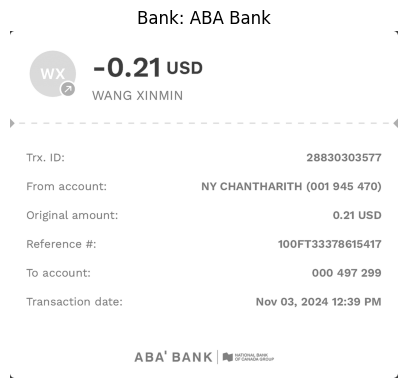

Extracted Transaction Data:
 []
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted bank: ABA Bank with confidence: 1.00
Could not extract any transactions from ABA statement (OCR text):
4 >
--. =6,022.50 KHR
<i Cell Card 1 (PIN-less)
Trx. ID: 36116045934
Consumer ID: 855 112 205 52
External #: 1630816901
From account: Mobile Joint Ny Chantharith (011
, 791 395)
Original amount: 1.50 USD
Reference #: 1OOFT34558258138
Transaction date: May 13, 2025 05:38 AM
ABA’ BANK | Ba sesusess..
, Jy
...


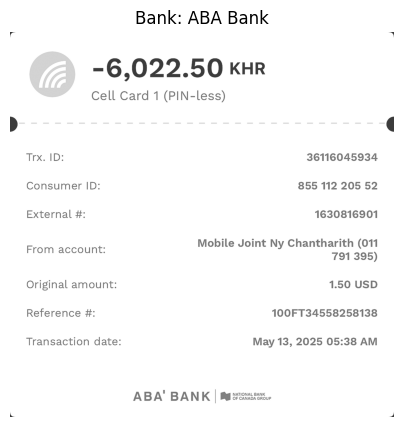

Extracted Transaction Data:
 []
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted bank: ABA Bank with confidence: 1.00
Could not extract any transactions from ABA statement (OCR text):
See UCR RAG at PE, Bag bp RE als Sat gon at en path outer ame le Bog ie ees ee oe wey Me? i i pelle Pal ee ae ies rr Me ha Fae eck eS ee ak ees es Tipe toe. wip ei eee
ON el eee ce ap lg Ne ee CR eee Bia |
pe eee ve ee feo: Seen pueeneee soe eat» es foe Bus SiGe ear neenG aon a fe oe
ae ya CNS es ea = ee ans
BG GUNS AE a Dae Ont eee pote ots Se alte et ein tere 4 Littell utes pe meee Gane Grew ome...


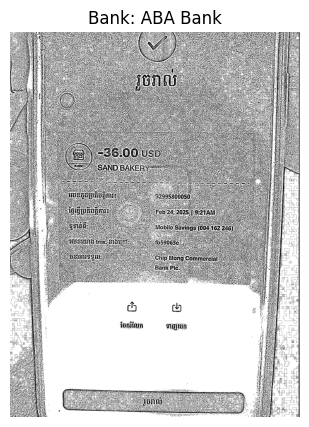

Extracted Transaction Data:
 []
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted bank: ABA Bank with confidence: 1.00
Could not extract any transactions from ABA statement (OCR text):
4 >
~—@  Cheahav HENG
Trx. ID: 28799639481
From account: NY CHANTHARITH (001 945 470)
Original amount: 11.25 USD
Reference #: 100FT33373164642
Remark: ZOlI cat payment
To account: 002 510 783
Transaction date: Nov 02, 2024 11:43 AM
ABA’ BANK | Be ereusees..
. y
...


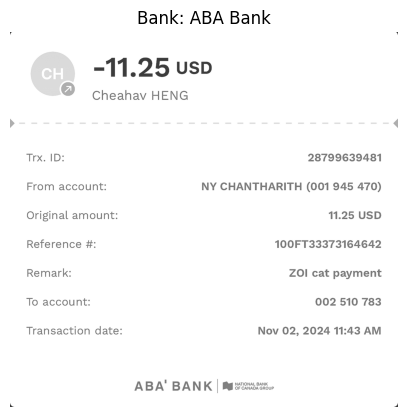

Extracted Transaction Data:
 []
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted bank: ABA Bank with confidence: 1.00
Could not extract any transactions from ABA statement (OCR text):
4 >
— =12.42 usp
© WANG XINMIN
Trx. ID: 29371599941
From account: Payment for Each month (002 271 953)
Original amount: 12.42 USD
Reference #: 100FT33465300490
To account: 000 497 299
Transaction date: Nov 19, 2024 07:52 AM
ABA’ BANK | Be sreusees..
7 y
...


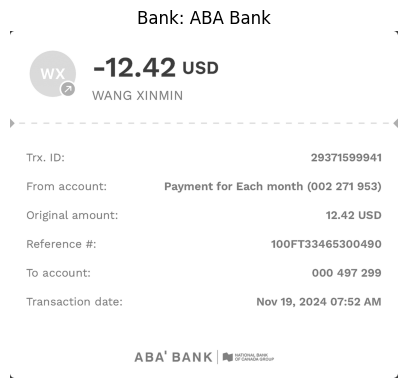

Extracted Transaction Data:
 []
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted bank: ABA Bank with confidence: 0.99
Could not extract any transactions from ABA statement (OCR text):
4 >

WX -3.82 usp
Transfer to WANG XINMIN
Trx. ID: 28224113085
From account: Save (006 693 368)
Original amount: 3.82 USD
Reference #: 1OOFT332/782 78310
To account: 000 497 299
Transaction date: Oct 15, 2024 11:36 AM
ABA’ BANK | Be sreusees..
. y
...


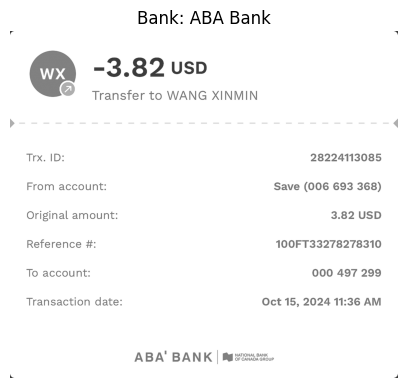

Extracted Transaction Data:
 []
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted bank: ABA Bank with confidence: 1.00
Could not extract any transactions from ABA statement (OCR text):
4 >
— =Q.19 usD
© WANG XINMIN
Trx. ID: 28195439515
From account: NY CHANTHARITH (001 945 470)
Original amount: 0.19 USD
Reference #: 1OOFT332 7467/7474
To account: 000 497 299
Transaction date: Oct 14, 2024 04:21 PM
ABA’ BANK | Be sreusees..
. y
...


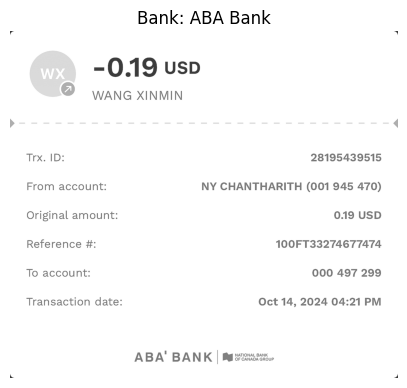

Extracted Transaction Data:
 []
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted bank: ABA Bank with confidence: 1.00
Could not extract any transactions from ABA statement (OCR text):
r |
“ 29,080.80 cur
Sy
Sand Bakery
Meta lprvime: 30014769414
Transaction date: Dec 06, 2024 03:45 PM
Original amount: 29,080.80 KHR
APV: 252929
iiNivisy v
a a)
iSniiGA Amti7
Ss
...


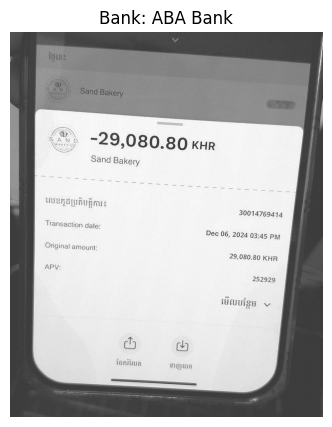

Extracted Transaction Data:
 []
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted bank: ABA Bank with confidence: 0.99
Could not extract any transactions from ABA statement (OCR text):
4 >
© WANG XINMIN
Trx. ID: 30266430486
From account: Save (006 693 368)
Original amount: 17.71 USD
Reference #: 1OOFT33602866098
To account: 000 497 299
Transaction date: Dec 13, 2024 10:00 AM
ABA’ BANK | Be sreusees..
. y
...


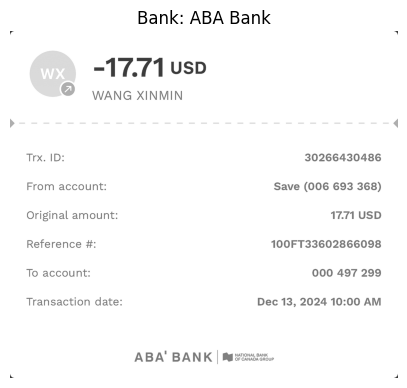

Extracted Transaction Data:
 []
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted bank: ABA Bank with confidence: 1.00
Could not extract any transactions from ABA statement (OCR text):
4 >
=» -6,000.00 KHR
:
HOMETOWN TECHNO
Trx. ID: 35827462014
Bakong hash #: e15ibde3
Bank: ACLEDA Bank Plc.
From account: Mobile Joint Ny Chantharith (011
, 791 395)
Original amount: 6,000.00 KHR
Reference #: 1OOFT34511624781
Seller: HOMETOWN TECHNO
Transaction date: May 06, 2025 02:18 PM
ABA’ BANK | Be ereusees..
S J
...


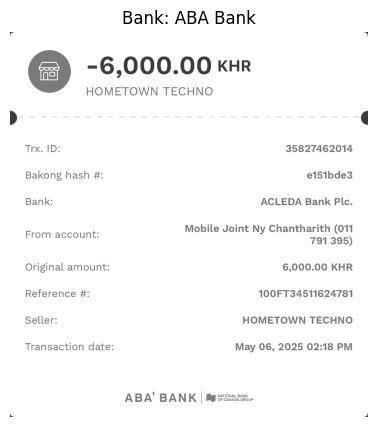

Extracted Transaction Data:
 []


In [16]:
model_path = "../src/backend/models/bank_classification.h5"
model = load_model(model_path)

CLASS_INDEXES =["ABA Bank", "ACLIDA Bank", "Other"]

folder_path = "../data/raw/Test/"

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', 'jpeg', 'PNG'))]

amount = []

for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    classified_image = classify_bank(image_path, model, CLASS_INDEXES)
    preprocessed_image = preprocess_image_advanced(image_path)
    if classified_image == "ABA Bank":
        extracted_data = extract_data_aba(preprocessed_image)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f"Bank: {classified_image}")
    plt.axis('off')
    plt.show()
    print(f"Extracted Transaction Data:\n {json.dumps(extracted_data, indent=2)}")
    

In [17]:
image_path = "preprocessed_photo_2025-03-24 23.35.50.jpeg"
# Load the image as a numpy array
img = np.array(Image.open(image_path).convert("L"))
extract_data = extract_data_aba(img)
print(extract_data)

Could not extract any transactions from ABA statement (OCR text):
| SAND BAKERY ii
Success inion
—— ~~
(‘@) -15.50 usp og _—_—
“7 SAND BAKERY eS Hl
A Transaction date: Feb 24, 2025 | ‘S217AM . a : !
y Paid from: Num —_— - f
i s — External trnx. ref: fe0249b6 —

; qq ' Receiving Bank: Chip Hone: Commercias |

Share Download [ag -
...
[]


# Extract with Khmer and English

In [18]:
import cv2
import pytesseract
import re
from PIL import Image
import numpy as np
import os

pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'  # adjust if needed

def preprocess_image_advanced(image_path, debug=False):
    """
    Preprocess an image for OCR, robust to both dark and light backgrounds.
    Crops to the transaction region, resizes, enhances, and inverts if needed.
    Optionally saves intermediate images for debugging.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    # Remove cropping to preserve all transaction data
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=3.0, fy=3.0, interpolation=cv2.INTER_LANCZOS4)
    mean_val = np.mean(gray)
    if mean_val < 127:
        gray = cv2.bitwise_not(gray)
    alpha = 0.9
    beta = 60
    adjusted = cv2.convertScaleAbs(gray, alpha=alpha, beta=beta)
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(adjusted, -1, kernel)
    normalized = cv2.normalize(sharpened, None, 0, 255, cv2.NORM_MINMAX)
    result = normalized
    # Always save the preprocessed image to temp_processing for traceability
    import os
    preproc_dir = os.path.join(os.path.dirname(image_path), '..', 'temp_processing')
    os.makedirs(preproc_dir, exist_ok=True)
    preproc_path = os.path.join(preproc_dir, f'preprocessed_{os.path.basename(image_path)}')
    cv2.imwrite(preproc_path, result)
    if debug:
        debug_dir = os.path.join(os.path.dirname(image_path), 'debug_preprocess')
        os.makedirs(debug_dir, exist_ok=True)
        cv2.imwrite(os.path.join(debug_dir, '01_gray.png'), gray)
        cv2.imwrite(os.path.join(debug_dir, '02_adjusted.png'), adjusted)
        cv2.imwrite(os.path.join(debug_dir, '03_sharpened.png'), sharpened)
        cv2.imwrite(os.path.join(debug_dir, '04_normalized.png'), normalized)
    return result

def extract_transaction_data(image_path):
    image = preprocess_image_advanced(image_path)
    
    # Khmer + English OCR
    text = pytesseract.image_to_string(image, lang='khm+eng', config='--oem 3 --psm 6')
    
    # Clean up
    lines = text.splitlines()
    lines = [line.strip() for line in lines if line.strip()]
    full_text = "\n".join(lines)

    # Extract Trx ID
    trx_id = None
    for line in lines:
        if "លេខកូដប្រតិបត្តិការ" in line or "លេខកូដ" in line or "Trx. ID" in line:
            match = re.search(r'\d{6,}', line)
            if match:
                trx_id = match.group()
                break

    # Extract Transaction Date
    trx_date = None
    for line in lines:
        if "ថ្ងៃធ្វើប្រតិបត្តិការ" in line or "Transaction date" in line:
            match = re.search(r'(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]* \d{2}, \d{4} \| \d{1,2}:\d{2}(AM|PM)', line)
            if match:
                trx_date = match.group()
                break

    # Extract Amount (top line)
    amount = None
    for line in lines:
        if re.search(r'-?\d{1,3}(,\d{3})*(\.\d{2})?\s*(KHR|USD)', line):
            match = re.search(r'(-?\d{1,3}(,\d{3})*(\.\d{2})?)\s*(KHR|USD)', line)
            if match:
                amount = f"{match.group(1)} {match.group(4)}"
                break

    return {
        "Transaction ID": trx_id,
        "Transaction Date": trx_date,
        "Amount": amount,
        "Full Text": full_text
    }

# Example usage:
test_folder = "../data/raw/Test/"
image_files = [f for f in os.listdir(test_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

all_results = []
for image_file in image_files:
    image_path = os.path.join(test_folder, image_file)
    result = extract_transaction_data(image_path)
    print(f"Result for {image_file}:\n{result}\n")
    all_results.append({"file": image_file, "data": result})


Result for IMG_6841.PNG:
{'Transaction ID': '28830303577', 'Transaction Date': None, 'Amount': '0.21 USD', 'Full Text': 'ស ខិ\n+. =Q.217 usb\n៩ WANG XINMIN\nTrx. ID: 28830303577\nFrom account: NY CHANTHARITH (001 945 470)\nOriginal amount: 0.21 USD\nReference #: 100FT333/78615417\nTo account: 000 497 299\nTransaction date: Nov 03, 2024 12:39 PM\nABA’ BANK | Be sreusees..\n. ច'}

Result for image_1747465308451.png:
{'Transaction ID': '36116045934', 'Transaction Date': None, 'Amount': '6,022.50 KHR', 'Full Text': '4 >\nៈ =6,022.50 KHR\n<i Cell Card 1 (PIN-less)\nTrx. ID: 36116045934\nConsumer ID: 855 112 205 52\nExternal #: 1630816901\nFrom account: Mobile Joint Ny Chantharith (011\n, 791 395)\nOriginal amount: 1.50 USD\nReference #: 1OOFT34558258138\nTransaction date: May 13, 2025 05:38 AM\nABA’ BANK | Ba sesusess..\nសែ ក'}

Result for photo_2025-03-24 23.35.48.jpeg:
{'Transaction ID': '32995800050', 'Transaction Date': 'Feb 24, 2025 | 9:27AM', 'Amount': None, 'Full Text': '7 (@ -36.00 

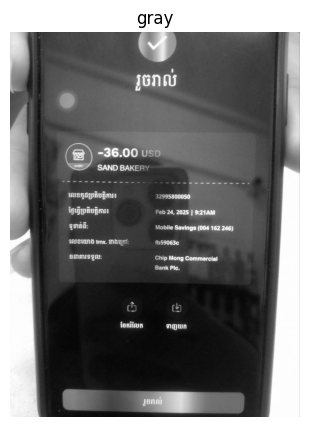

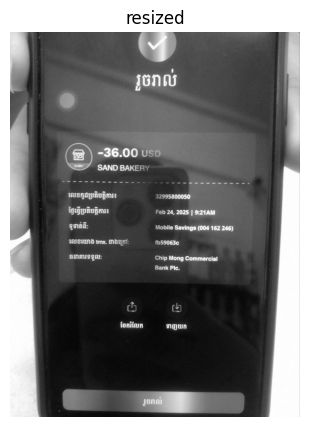

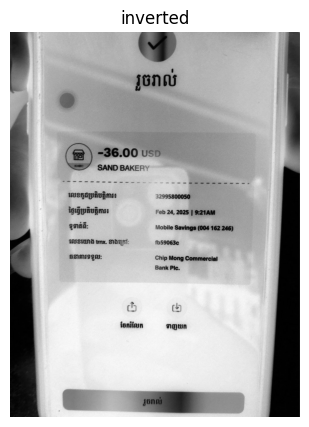

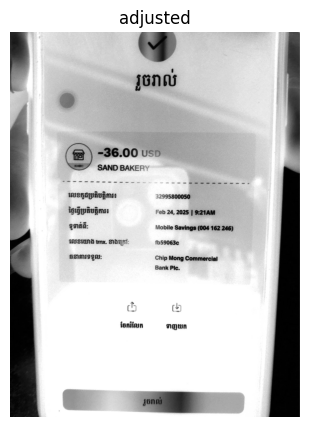

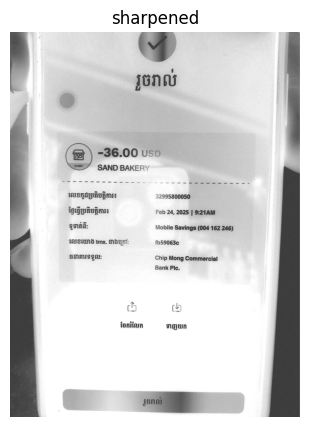

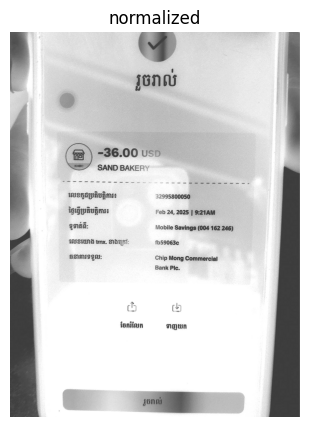

In [4]:
def show_preprocessing_steps(image_path, debug=False, save_dir="preprocessing"):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    steps = {}

    # Gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    steps['gray'] = gray

    # Resized
    gray_resized = cv2.resize(gray, None, fx=3.0, fy=3.0, interpolation=cv2.INTER_LANCZOS4)
    steps['resized'] = gray_resized

    # Invert if dark
    mean_val = np.mean(gray_resized)
    if mean_val < 127:
        gray_inverted = cv2.bitwise_not(gray_resized)
        steps['inverted'] = gray_inverted
        gray_for_next = gray_inverted
    else:
        gray_for_next = gray_resized

    # Adjusted
    alpha = 0.9
    beta = 60
    adjusted = cv2.convertScaleAbs(gray_for_next, alpha=alpha, beta=beta)
    steps['adjusted'] = adjusted

    # Sharpened
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(adjusted, -1, kernel)
    steps['sharpened'] = sharpened

    # Normalized
    normalized = cv2.normalize(sharpened, None, 0, 255, cv2.NORM_MINMAX)
    steps['normalized'] = normalized

    # Thresholded (if light background)
    if mean_val >= 127:
        thresh = cv2.adaptiveThreshold(
            normalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2
        )
        steps['thresh'] = thresh

    # Create save directory if it doesn't exist
    save_dir = "preprocessing"
    os.makedirs(save_dir, exist_ok=True)

    # Plot and save each step one by one
    for name, img in steps.items():
        plt.figure(figsize=(5, 5))
        plt.imshow(img, cmap='gray')
        plt.title(name)
        plt.axis('off')
        plt.show()
        # Save the image
        save_path = os.path.join(save_dir, f"{name}_{os.path.basename(image_path)}")
        cv2.imwrite(save_path, img)

# Example usage:
image_path_1 = "../data/raw/Test/photo_2025-03-24 23.35.48.jpeg"
show_preprocessing_steps(image_path_1)

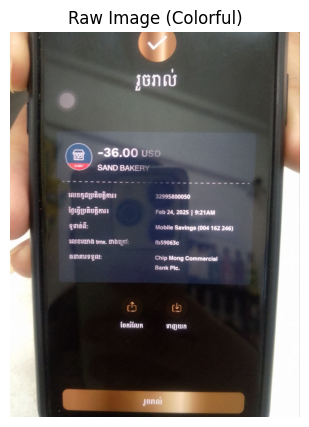

In [20]:
img_color = cv2.imread(image_path_1, cv2.IMREAD_COLOR)
# Convert BGR (OpenCV default) to RGB for matplotlib
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(img_rgb)
plt.title("Raw Image (Colorful)")
plt.axis('off')
plt.show()

In [23]:
result = extract_transaction_data(image_path_1)
print(f"Result for {image_path_1}:\n{result}\n")

Result for ../data/raw/Test/photo_2025-03-24 23.35.48.jpeg:
{'Transaction ID': '32995800050', 'Transaction Date': 'Feb 24, 2025 | 9:27AM', 'Amount': None, 'Full Text': '7 (@ -36.00 Usd ‘\nq “== SAND BAKERY me\n’ លេខកូដប្រតិបត្តិការ៖ 32995800050\nថ្ងៃធ្វើប្រតិបត្តិការ៖ Feb 24, 2025 | 9:27AM\na. ទូទាត់ពី: Mobile Savings (004 162 246)\n” i លេខយោង tmx. ខាងក្រៅ- 59063០\n4 ធនាគារទទួល: Chip Mong Commercial\na Bank Pic. |\nចែករំលែក ទាញយក .\n: |'}

